In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('WMA_fractions_v2.csv', skiprows=1)

In [27]:
df.head()

,Arctic_Surface_Water_[fraction],Modified_summer_Pacific_Water_[fraction],Summer_Pacific_Water_[fraction],Winter_Pacific_Water_[fraction],Norwegian_Current_Water_[fraction],Atlantic_Water_[fraction],Brine-enriched_Water_[fraction],Conservative_Temperature_[deg_C],Absolute_Salinity_[PSU],Latitude_[deg_N],Depth_[m],Longitude_[deg_E],Dissolved_Oxygen_[micro_mol_per_kg],Datetime_[UTC],Source,Profile_Number
0,0.000000,0.000000,0.002680,0.000000,0.997320,0.000000,0.000000,9.222,35.352,63.315,15.0,-0.075,NaN,2009-08-09,argo,1
1,0.000154,0.000148,0.000496,0.000102,0.995409,0.003583,0.000107,7.958,35.402,63.317,105.0,-0.017,NaN,2009-08-09,argo,1
2,0.000322,0.000295,0.000327,0.000134,0.979148,0.019728,0.000046,7.831,35.402,63.318,115.0,-0.090,NaN,2009-08-09,argo,1
3,0.000274,0.000256,0.000259,0.000111,0.965319,0.033748,0.000033,7.724,35.400,63.309,125.0,-0.068,NaN,2009-08-09,argo,1
4,0.000124,0.000116,0.000117,0.000051,0.944119,0.055455,0.000017,7.550,35.395,63.368,135.0,-0.018,NaN,2009-08-09,argo,1


In [28]:
df_STO = df[['Conservative_Temperature_[deg_C]', 'Absolute_Salinity_[PSU]', 'Dissolved_Oxygen_[micro_mol_per_kg]','Longitude_[deg_E]', 'Latitude_[deg_N]','Datetime_[UTC]']].copy()
df_STO = df_STO.dropna()

In [29]:
df_STO.rename(columns={"Longitude_[deg_E]": "lon", "Latitude_[deg_N]": "lat", "Datetime_[UTC]": "date"}, inplace=True)

In [35]:
df_STO["date"] = pd.to_datetime(df_STO["date"])
df_STO["date.month"] = df_STO["date"].dt.month


In [36]:
df_STO.head()

,Conservative_Temperature_[deg_C],Absolute_Salinity_[PSU],Dissolved_Oxygen_[micro_mol_per_kg],lon,lat,date,date.month
450,7.568,35.200,299.264,3.994,69.893,2022-06-14,6
451,7.529,35.199,298.703,3.930,69.870,2022-06-12,6
452,6.170,35.250,296.322,3.919,69.895,2022-06-12,6
453,6.138,35.252,295.827,4.025,69.870,2022-06-12,6
454,6.091,35.252,295.818,3.960,69.884,2022-06-12,6


In [5]:
print(df['Longitude_[deg_E]'].max())
print(df['Latitude_[deg_N]'].max())

print(df['Longitude_[deg_E]'].min())
print(df['Latitude_[deg_N]'].min())



179.999
90.0
-179.997
47.165


In [6]:
# # Create bins of lat and lon
# lon_bins = pd.interval_range(start=df['Longitude_[deg_E]'].min(), end=df['Longitude_[deg_E]'].max(), freq=30)
# lat_bins = pd.interval_range(start=df['Latitude_[deg_N]'].min(), end=df['Latitude_[deg_N]'].max(), freq=30)

In [41]:
# Peisong code (edited)
import xarray as xr
import numpy as np
import seaborn as sns

def cal_threshold(
    ds: xr.Dataset,
    lat_step: float,
    lon_step: float,
    quantile: float
) -> int:
    """
    Calculate the threshold based on the difference between adjacent elements in the sorted latitude-longitude bins.

    Args:
        ds (xr.Dataset): The dataset.
        lat_step (float): The latitude step size for binning.
        lon_step (float): The longitude step size for binning.
        quantile (float): The quantile value for threshold calculation.

    Returns:
        int: The calculated threshold.
    """
    if ds is type(xr.DataArray):
        df_latlon = ds[['lat', 'lon']].to_dataframe()
    else:
        df_latlon = ds

    lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180, 185, lon_step))
    lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90, 95, lat_step))

    latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

    g_len = []
    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            # print(f"Group {group_key}: {len(group)} rows")
            g_len.append(len(group))
        except KeyError:
            # Handle the KeyError gracefully
            print(f"No data points for group {group_key}")

    g_len_sorted = sorted(g_len)
    transition_point = None

    g_len_diff = np.diff(g_len_sorted)

    threshold = np.quantile(g_len_diff, quantile)  # set a threshold for the difference between adjacent elements

    for i in range(1, len(g_len_sorted)):
        if g_len_sorted[i] - g_len_sorted[i-1] > threshold:
            transition_point = i - 1
            break

    return g_len_sorted[transition_point]

def drop_profiles(
    ds: xr.Dataset,
    lat_step: float,
    lon_step: float,
    threshold: int
) -> xr.Dataset:
    """
    Drop the profiles in the bins with sample size larger than the threshold.

    Args:
        ds (xr.Dataset): The dataset.
        lat_step (float): The latitude step size for binning.
        lon_step (float): The longitude step size for binning.
        threshold (int): The threshold for dropping profiles.

    Returns:
        xr.Dataset: The dataset with profiles dropped.
    """
    if ds is type(xr.DataArray):
        df_latlon = ds[['lat', 'lon']].to_dataframe()
    else:
        df_latlon = ds

    lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180, 185, lon_step))
    lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90, 95, lat_step))

    latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

    latlon_groups_list = []

    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            if len(group) > threshold:
                group_drop = group.sample(n=len(group)-threshold, random_state=0)
                latlon_groups_list.append(group_drop)
        except KeyError:
            print(f"No data points for group {group_key}")

    ds_spatially_sampled = ds.copy()

    nprof_dropped = []

    for group in latlon_groups_list:
        temp_index = group.index.values
        nprof_dropped.append(temp_index.tolist())

    nprof_dropped = [item for sublist in nprof_dropped for item in sublist]

    return ds_spatially_sampled


########################################################################################################################


# def ramdon_sample_by_month(
#     ds: xr.Dataset,
#     ratio: float,
#     random_seed: int = 0
# ) -> xr.Dataset:
#     """
#     Sample profiles by month based on a given ratio.

#     Args:
#         ds (xr.Dataset): The dataset.
#         ratio (float): The ratio of profiles to sample (between 0 and 1).
#         random_seed (int, optional): The random seed for reproducibility. Defaults to 0.

#     Returns:
#         xr.Dataset: The dataset with sampled profiles.
#     """
#     if ratio < 0 or ratio > 1:
#         raise ValueError("Ratio must be between 0 and 1.")

#     if 'date' not in ds:
#         raise ValueError("Input dataset must have a 'date' variable.")

#     # if 'nprof' not in ds.dims:
#     #     raise ValueError("Input dataset must have a 'nprof' dimension.")

#     ds_monthly = ds.groupby('date.month')
#     months_with_data = [month for month in ds_monthly.groups.keys() if len(ds_monthly[month]) > 0]

#     if not months_with_data:
#         raise ValueError("Input dataset does not contain any data.")

#     smallest_month_size = np.min([ds_monthly[month].nprof.size for month in months_with_data])
#     selected_size_monthly = ds.nprof.size * ratio / 12

#     if smallest_month_size < selected_size_monthly:
#         selected_size_monthly = smallest_month_size
#         print(f"Ratio is too large, selected_size_monthly is reset to the smallest_month_size: {smallest_month_size}")

#     ds_selected = xr.concat([ds_monthly[month].isel(nprof=np.random.default_rng(random_seed).choice(ds_monthly[month].nprof.size, int(selected_size_monthly), replace=False)) for month in months_with_data], dim='nprof')

#     ds_selected['nprof'] = np.arange(ds_selected.sizes['nprof'])

#     return ds_selected

def latlon_bining_ana(ds):
    lat_bins=[2,5,10]
    lon_bins=[10,20,30,40,50,60,70,80]
    ds_len=[]
    threshold=[]
    for i in lat_bins:
        for j in lon_bins:
            # T=cal_threshold(ds, i, j, quantile=0.95)
            T=int(cal_threshold(ds, i, j, quantile=0.95))
            ds_spatially_sampled = drop_profiles(ds, i, j, T)
            #ds_monthly_sampled = ramdon_sample_by_month(ds_spatially_sampled, 1, random_seed=0)
            threshold.append(T)
            #ds_len.append(ds_monthly_sampled.nprof.size)

    threshold=np.array(threshold)
    threshold=threshold.reshape(len(lat_bins),len(lon_bins))
    threshold=threshold.T
    threshold=pd.DataFrame(threshold,index=lon_bins,columns=lat_bins)

    # plot the ds_len changes with i and j as line plot
    ds_len=np.array(ds_len)
    ds_len=ds_len.reshape(len(lat_bins),len(lon_bins))
    ds_len=ds_len.T
    ds_len=pd.DataFrame(ds_len,index=lon_bins,columns=lat_bins)

    # plot the heatmap of the threshold and number of profiles
    fig, axs = plt.subplots(1, 2, figsize=(14, 6),dpi=300)
    sns.set_theme(style="whitegrid")

    # plot the heatmap of the threshold
    sns.heatmap(threshold, annot=True, linewidths=.5, cmap='YlGnBu', ax=axs[0])
    axs[0].set_title('Threshold')
    axs[0].set_xlabel('Latitude bin')
    axs[0].set_ylabel('Longitude bin')

    # plot the heatmap of the number of profiles
    sns.heatmap(ds_len, annot=True, linewidths=.5, cmap='YlGnBu', ax=axs[1])
    axs[1].set_title('Number of profiles')
    axs[1].set_xlabel('Latitude bin')
    axs[1].set_ylabel('Longitude bin')
    
    plt.show()

In [42]:
latlon_bining_ana(df_STO)

/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

No data points for group (nan, Interval(70, 72, closed='right'))
No data points for group (nan, Interval(72, 74, closed='right'))
No data points for group (nan, Interval(74, 76, closed='right'))
No data points for group (nan, Interval(76, 78, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(70, 72, closed='right'))
No data points for group (nan, Interval(72, 74, closed='right'))
No data points for group (nan, Interval(74, 76, closed='right'))
No data points for group (nan, Interval(76, 78, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

No data points for group (nan, Interval(70, 72, closed='right'))
No data points for group (nan, Interval(72, 74, closed='right'))
No data points for group (nan, Interval(74, 76, closed='right'))
No data points for group (nan, Interval(76, 78, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(70, 72, closed='right'))
No data points for group (nan, Interval(72, 74, closed='right'))
No data points for group (nan, Interval(74, 76, closed='right'))
No data points for group (nan, Interval(76, 78, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(50, 52, closed='right'))
No data points for group (nan, Interval(68, 70, closed='right'))
No data points for group (nan, Interval(70, 72, closed='right'))
No data points for group (nan, Interval(72, 74, closed='right'))
No data points for group (nan, Interval(74, 76, closed='right'))
No data points for group (nan, Interval(76, 78, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(50, 52, closed='right'))
No data points for group (nan, Interval(68, 70, closed='right'))
No data points for group (nan, Interval(70, 72, closed='right'))
No data points for group (nan, Interval(72, 74, closed='right'))
No data points for group (nan, Interval(74, 76, closed='right'))
No data points for group (nan, Interval(76, 78, closed='right'))
No data points for group (nan, Interval(78, 80, closed='right'))
No data points for group (nan, Interval(80, 82, closed='right'))
No data points for group (nan, Interval(82, 84, closed='right'))
No data points for group (nan, Interval(84, 86, closed='right'))
No data points for group (nan, Interval(86, 88, closed='right'))
No data points for group (nan, Interval(88, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

No data points for group (nan, Interval(70, 75, closed='right'))
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(70, 75, closed='right'))
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

No data points for group (nan, Interval(70, 75, closed='right'))
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(70, 75, closed='right'))
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(50, 55, closed='right'))
No data points for group (nan, Interval(65, 70, closed='right'))
No data points for group (nan, Interval(70, 75, closed='right'))
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(50, 55, closed='right'))
No data points for group (nan, Interval(65, 70, closed='right'))
No data points for group (nan, Interval(70, 75, closed='right'))
No data points for group (nan, Interval(75, 80, closed='right'))
No data points for group (nan, Interval(80, 85, closed='right'))
No data points for group (nan, Interval(85, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

No data points for group (nan, Interval(70, 80, closed='right'))
No data points for group (nan, Interval(80, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(70, 80, closed='right'))
No data points for group (nan, Interval(80, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])
/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

No data points for group (nan, Interval(70, 80, closed='right'))
No data points for group (nan, Interval(80, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(70, 80, closed='right'))
No data points for group (nan, Interval(80, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(50, 60, closed='right'))
No data points for group (nan, Interval(60, 70, closed='right'))
No data points for group (nan, Interval(70, 80, closed='right'))
No data points for group (nan, Interval(80, 90, closed='right'))


/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_62627/1762378169.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df_latlon.groupby([lon_bins, lat_bins])


No data points for group (nan, Interval(50, 60, closed='right'))
No data points for group (nan, Interval(60, 70, closed='right'))
No data points for group (nan, Interval(70, 80, closed='right'))
No data points for group (nan, Interval(80, 90, closed='right'))


ValueError: cannot reshape array of size 0 into shape (3,8)

In [65]:
df_STO.head()

,Conservative_Temperature_[deg_C],Absolute_Salinity_[PSU],Dissolved_Oxygen_[micro_mol_per_kg],lon,lat,date,date.month
450,7.568,35.200,299.264,3.994,69.893,2022-06-14,6
451,7.529,35.199,298.703,3.930,69.870,2022-06-12,6
452,6.170,35.250,296.322,3.919,69.895,2022-06-12,6
453,6.138,35.252,295.827,4.025,69.870,2022-06-12,6
454,6.091,35.252,295.818,3.960,69.884,2022-06-12,6


In [69]:
import pandas as pd
import numpy as np

def sample_by_lat_lon_bins(
    df,
    bin_sizes=(2, 2),
    total_samples=None,
    fraction=None,
    strategy="equal",   # "equal" or "proportional"
    replace=False,
    random_state=None
):
    lat_size, lon_size = bin_sizes

    # Determine how many samples
    if fraction is not None:
        total_samples = int(round(len(df) * fraction))
    if total_samples is None:
        total_samples = len(df)

    df = df.copy()

    # Build bins
    lat_bins = np.arange(df.lat.min(), df.lat.max() + lat_size, lat_size)
    lon_bins = np.arange(df.lon.min(), df.lon.max() + lon_size, lon_size)

    df["_lat_bin"] = pd.cut(df["lat"], bins=lat_bins, include_lowest=True)
    df["_lon_bin"] = pd.cut(df["lon"], bins=lon_bins, include_lowest=True)

    # Drop unbinned rows
    df_binned = df.dropna(subset=["_lat_bin", "_lon_bin"])

    # Group by bins
    grouped = df_binned.groupby(["_lat_bin", "_lon_bin"], observed=True)

    # Extract bin info directly from the groups
    bins = []
    counts = []
    for key, group in grouped:
        bins.append(key)          # key = (lat_interval, lon_interval)
        counts.append(len(group))

    bin_info = pd.DataFrame({"bin": bins, "count": counts})
    n_bins = len(bin_info)

    # Allocate samples
    if strategy == "equal":
        base = total_samples // n_bins
        remainder = total_samples - base * n_bins
        bin_info["target"] = base
        if remainder > 0:
            bin_info.loc[:remainder - 1, "target"] += 1

    elif strategy == "proportional":
        total_count = bin_info["count"].sum()
        raw = bin_info["count"] / total_count * total_samples
        bin_info["target"] = np.floor(raw).astype(int)
        remainder = total_samples - bin_info["target"].sum()
        if remainder > 0:
            frac = raw - np.floor(raw)
            idx = np.argsort(-frac)[:remainder]
            bin_info.loc[idx, "target"] += 1

    else:
        raise ValueError("strategy must be 'equal' or 'proportional'")

    # --- SAMPLE ---
    sampled_parts = []
    for (lat_bin, lon_bin), target in zip(bin_info["bin"], bin_info["target"]):
        group = grouped.get_group((lat_bin, lon_bin))

        # Sample without replacement until group limit
        if (len(group) < target) and not replace:
            sampled_parts.append(group)
        else:
            sampled_parts.append(group.sample(target, replace=replace, random_state=random_state))

    sampled_df = pd.concat(sampled_parts).reset_index(drop=True)

    # Clean temporary columns
    sampled_df = sampled_df.drop(columns=["_lat_bin", "_lon_bin"])

    return sampled_df


In [105]:
df_sampled = sample_by_lat_lon_bins(
    df_STO,
    bin_sizes=(2, 2),
    total_samples=1000000,
    strategy="equal",
    random_state=22)

In [88]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.scatter(df_STO['lon'], df_STO['lat'], color='lightgray', alpha=0.5, label='Original Data', s=5)
# plt.scatter(df_sampled['lon'], df_sampled['lat'], color='red', alpha=0.7, label='Sampled Data', s=10)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

In [106]:
df_sampled.shape

(359788, 7)

In [107]:
df_sampled.head()

,Conservative_Temperature_[deg_C],Absolute_Salinity_[PSU],Dissolved_Oxygen_[micro_mol_per_kg],lon,lat,date,date.month
0,11.924,32.564,289.96,-128.37,49.629,2008-07-04,7
1,11.914,32.538,289.83,-128.37,49.629,2008-07-04,7
2,6.893,33.463,224.49,-128.37,49.629,2008-07-04,7
3,6.926,33.841,183.04,-128.37,49.629,2008-07-04,7
4,6.783,33.959,164.99,-128.37,49.629,2008-07-04,7


In [110]:
from sklearn.cluster import DBSCAN
df_sampled = df_sampled[['Conservative_Temperature_[deg_C]', 'Absolute_Salinity_[PSU]', 'Dissolved_Oxygen_[micro_mol_per_kg]', 'lon', 'lat']]
db = DBSCAN(eps=0.01, min_samples=1000000).fit(df_sampled)
labels = db.labels_

Text(0.5, 1.0, 'DBSCAN Clustering for Sampled Data')

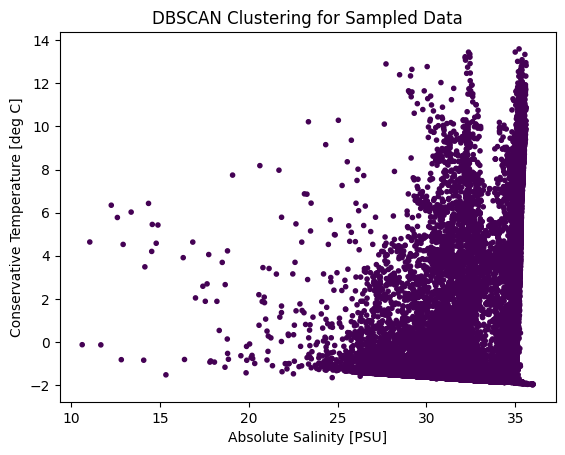

In [111]:
plt.scatter(df_sampled['Absolute_Salinity_[PSU]'], df_sampled['Conservative_Temperature_[deg_C]'], c=labels, marker='.')
plt.xlabel('Absolute Salinity [PSU]')
plt.ylabel('Conservative Temperature [deg C]')
plt.title('DBSCAN Clustering for Sampled Data')